In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import random

In [3]:
names = open('names.txt').read().split('\n')
chars = {'.':0,}
set_chars = set()
for i in names:
    for j in str(i):
        set_chars.add(j)
for i, letter in enumerate(sorted(list(set_chars))):
    chars[letter] = i + 1
keys_chars = list(chars.keys())

In [4]:
#  ... e
#  ..e m
#  .em m
#  emm a
#  mma .
X, Y = [], []
prev_lett = 8

for name in names:
    list_to_loop_of_names = ['.'] + list(name) + ['.']
    for letter in range(len(list_to_loop_of_names)-1):
        X_here, k = [], 0
        while prev_lett-letter-k > 0:
            X_here.append(0)
            k += 1
        while len(X_here) < prev_lett:
            # print(letter, len(X_here))
            X_here.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
        X.append(X_here)
        Y.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
X = torch.tensor(X)
Y = torch.tensor(Y)


In [5]:
def make_dataset(names):
    Xs, Ys = [], []
    for name in names:
        list_to_loop_of_names = ['.'] + list(name) + ['.']
        for letter in range(len(list_to_loop_of_names)-1):
            X_here, k = [], 0
            while prev_lett-letter-k > 0:
                X_here.append(0)
                k += 1
            while len(X_here) < prev_lett:
                X_here.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
            Xs.append(X_here)
            Ys.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
    return torch.tensor(Xs), torch.tensor(Ys)
random.shuffle(names)
n1, n2 = int(0.8 * len(names)), int(0.9 * len(names))
Xtrain, Ytrain = make_dataset(names[:n1])
Xval, Yval = make_dataset(names[n1:n2])
Xtest, Ytest = make_dataset(names[n2:])

In [77]:
class Linear:
    
    def __init__(self, inp_neur, out_neur, bias_req=True):
        self.weights = torch.randn((inp_neur, out_neur), generator=g) / inp_neur**0.5
        if bias_req: self.bias = torch.zeros(out_neur)
        else:        self.bias = None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias != None: self.out += self.bias
        return self.out

    def params(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])


class Embedding:
  
  def __init__(self, num_embeddings, num_dim):
    self.weight = torch.randn((num_embeddings, num_dim), generator=g)
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def params(self):
    return [self.weight]

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def params(self):
        return []
        

class batchNormal:
    def __init__(self, neur, calc_mean=True, e=0.0001, momentum=0.1):
        self.momentum = momentum
        self.e = e
        self.weights = torch.ones(neur)
        self.bias = torch.zeros(neur)
        self.training = True

        self.mean_mean = torch.zeros(neur)
        self.std_mean = torch.ones(neur)

    def __call__(self, x):
        if self.training:
            x_mean_now = x.mean(0, keepdims=True)
            x_std_now = x.var(0, keepdim=True)
        else:
            x_mean_now = self.mean_mean
            x_std_now = self.std_mean
        xhat = (x - x_mean_now) / torch.sqrt(x_std_now + self.e) # normalize to unit variance
        self.out = self.weights * xhat + self.bias
        # self.out = self.weights * (x - x_mean_now)/torch.sqrt(x_std_now + self.e) + self.bias

        if self.training:
            with torch.no_grad():
                self.mean_mean = (1 - self.momentum) * self.mean_mean + self.momentum * x_mean_now
                self.std_mean = (1 - self.momentum) * self.std_mean + self.momentum * x_std_now

        return self.out
        
    def params(self):
        return [self.weights, self.bias]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def params(self):
        return []

In [78]:
# CONSTS 
num_dim = 30
num_input = prev_lett * num_dim
num_W1 = 100
num_W2 = 27
batch_size = 32

In [79]:
g = torch.Generator()
g.manual_seed(2147483647)
# C = torch.randn((27, num_dim), generator=g)
layers = [
    Embedding(27, num_dim),
    Flatten(),
    Linear(num_input, num_W1), batchNormal(num_W1), Tanh(),
    Linear(num_W1, num_W2),
]

P = [p for layer in layers for p in layer.params()]
print(sum(p.nelement() for p in P))

for p in P:
    p.requires_grad = True

27837


In [80]:
epochs = 70000
steps, losses = [], []
for epoch in range(epochs):
    samples_on_this_epoch = torch.randint(0, len(Xtrain), (batch_size,), generator=g)
    X_on_this_epoch = Xtrain[samples_on_this_epoch]
    Y_on_this_epoch = Ytrain[samples_on_this_epoch]
    # print(C[Xtrain[samples_on_this_epoch]].shape[0])
    
    for layer in layers:
        X_on_this_epoch = layer(X_on_this_epoch)
        # print(X_on_this_epoch.shape)
    loss = F.cross_entropy(X_on_this_epoch, Y_on_this_epoch)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in P:
        p.grad = None
        
    loss.backward()
    lr = 0.1 if epoch/epochs < 0.3 else 0.01

    for p in P:
        p.data += -lr * p.grad

    # steps.append(epoch)
    losses.append(loss.item())


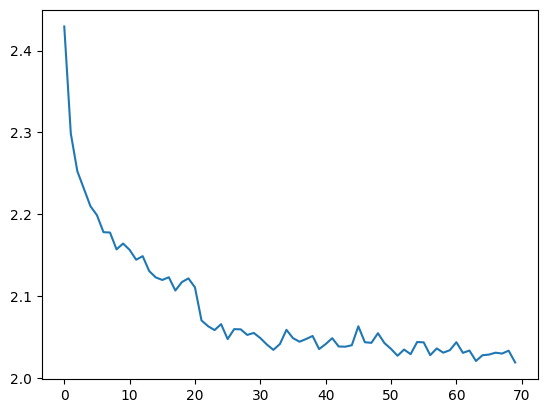

In [100]:
losses_tensor = torch.tensor(losses).view(-1, 1000).mean(1)
steps = torch.arange(losses_tensor.shape[-1])
plt.plot(steps, losses_tensor);

In [82]:
for layer in layers:
    layer.training = False

In [86]:
@torch.no_grad()
def check_loss(dataX, dataY):
    losses_checker = []
    # for i in range(100):
    X_on_this_epoch = dataX
    Y_on_this_epoch = dataY
    for layer in layers:
        X_on_this_epoch = layer(X_on_this_epoch)
    
    loss = F.cross_entropy(X_on_this_epoch, Y_on_this_epoch)
    losses_checker.append(loss.item())
    return torch.tensor(losses_checker).mean().item()

In [87]:
print(check_loss(Xval, Yval))
print(check_loss(Xtest, Ytest))

2.0634329319000244
2.053928852081299


In [90]:
examples = []
for i in range(15):
    inp_letters = [0] * prev_lett
    example = []
    while True:
        lol = torch.tensor(inp_letters)
        X_on_this_epoch = lol.view(1, 8)
        
        for layer in layers:
            X_on_this_epoch = layer(X_on_this_epoch)
            # print(X_on_this_epoch.shape)
        
        probs = F.softmax(X_on_this_epoch, dim=1)
        letter = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        inp_letters.append(letter)
        inp_letters.pop(0)
        example.append(keys_chars[letter])
        letter = keys_chars[letter]
        if letter == '.':
            break
    examples.append(''.join(example))
print(examples)

['evena.', 'zehiel.', 'nyen.', 'deoper.', 'adelsi.', 'lawan.', 'riwent.', 'bannnech.', 'maith.', 'kaiyan.', 'adnalith.', 'andelise.', 'kamir.', 'castida.', 'zayver.']
